In [1]:
import math
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import itertools

from ema_workbench import save_results, load_results
from ema_workbench.analysis import parcoords
from ema_workbench.analysis import clusterer, plotting, Density

#%matplotlib inline
clr_palette = ([sns.color_palette("YlGn", 15)[10],sns.cubehelix_palette(8)[6]])

pydice_folder = "C:/Users/ivart/OneDrive/Bureaublad/Afstuderen/WRR/PyRICE Ivar Tjallingii/PyRICE2020/6_Uncertainty Analysis/model_server"
sys.path.append(pydice_folder)

from ema_workbench import (perform_experiments, Model, Policy, Scenario, ReplicatorModel, RealParameter, IntegerParameter, ScalarOutcome, ArrayOutcome, 
                           Constant, ema_logging, SequentialEvaluator, MultiprocessingEvaluator, IpyparallelEvaluator)

from PyRICE_V9_short_term_uncertainty import PyRICE

from matplotlib import pyplot

C:\Users\ivart\anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


In [2]:
results_total_short_term = pd.read_csv("experiments_short_term_uncertainty_total.csv")

results_total_short_term['Economic scenario'] = ""#df.loc[df['c1'] == 'Value', 'c2'] = 10
results_total_short_term.loc[results_total_short_term["scenario_pop_gdp"] == 0,'Economic scenario'] = "Nordhaus scenario"
results_total_short_term.loc[results_total_short_term["scenario_pop_gdp"] == 1,'Economic scenario'] = "SSP1"
results_total_short_term.loc[results_total_short_term["scenario_pop_gdp"] == 2,'Economic scenario'] = "SSP2"
results_total_short_term.loc[results_total_short_term["scenario_pop_gdp"] == 3,'Economic scenario'] = "SSP3"
results_total_short_term.loc[results_total_short_term["scenario_pop_gdp"] == 4,'Economic scenario'] = "SSP4"
results_total_short_term.loc[results_total_short_term["scenario_pop_gdp"] == 5,'Economic scenario'] = "SSP5"

In [3]:
list(results_total_short_term.columns)

experiments_columns = ['fdamage',
 'fosslim',
 'scenario_cback',
 'scenario_elasticity_of_damages',
 'scenario_limmiu',
 'scenario_pop_gdp',
 'scenario_sigma',
 't2xco2_dist',
 't2xco2_index',
 'scenario',
 'policy',
 'model',
 'sr',
 'irstp',
 'miu_period',
 'egalitarian_discounting',
 'principle',
 'sufficitarian growth factor',
 'sufficitarian_discounting',
 'treshold level',
 'growth_factor_prio',
 'prioritarian_discounting']

In [4]:
experiments = results_total_short_term[experiments_columns]

In [5]:
experiments = results_total_short_term[experiments_columns]
outcomes = results_total_short_term.iloc[:,18:142]

In [6]:
#combine growth factors
experiments['growth factor'] = np.where(experiments['growth_factor_prio'] > 0,experiments['growth_factor_prio'] ,"else")
experiments['growth factor'] = np.where(experiments['sufficitarian growth factor'] >0,experiments['sufficitarian growth factor'] ,"else")
#experiments['growth factor'] = np.where(experiments['growth factor'] =="else",0.0 ,experiments['growth factor'])

#combine discounting
experiments['discounting_method'] = ""
experiments['discounting_method'] = np.where(experiments['principle'] == "utilitarian" , experiments['irstp'], 0)
experiments['discounting_method'] = np.where(experiments['irstp'] > 0.005 , 0, 1)

experiments['discounting_method'] = np.where(experiments['prioritarian_discounting'] == 0, 2,experiments['discounting_method'])
experiments['discounting_method'] = np.where(experiments['prioritarian_discounting'] == 1, 3,experiments['discounting_method'])

experiments['discounting_method'] = np.where(experiments['sufficitarian_discounting'] == 0,4 ,experiments['discounting_method'])
experiments['discounting_method'] = np.where(experiments['sufficitarian_discounting'] == 1,5 ,experiments['discounting_method'])

experiments['discounting_method'] = np.where(experiments['egalitarian_discounting'] == 0, 6 ,experiments['discounting_method'])
experiments['discounting_method'] = np.where(experiments['egalitarian_discounting'] ==1, 7,experiments['discounting_method'])

#treshold level
experiments['treshold level'] = np.where(experiments['principle'] != "Sufficitarian"  , 0.7,experiments['treshold level'])

#principle
experiments['principle_recoded'] = 0
experiments['principle_recoded'] = np.where(experiments['principle'] == "Nordhaus policy" , int(4), experiments['principle_recoded'])
experiments['principle_recoded'] = np.where(experiments['principle'] == "Utilitarian" , int(0), experiments['principle_recoded'])
experiments['principle_recoded'] = np.where(experiments['principle'] == "Prioritarian" , int(1), experiments['principle_recoded'])
experiments['principle_recoded'] = np.where(experiments['principle'] == "Sufficitarian" , int(2), experiments['principle_recoded'])
experiments['principle_recoded'] = np.where(experiments['principle'] == "Egalitarian" , int(3), experiments['principle_recoded'])

<ipython-input-6-43dfb4ef5794>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experiments['growth factor'] = np.where(experiments['growth_factor_prio'] > 0,experiments['growth_factor_prio'] ,"else")
<ipython-input-6-43dfb4ef5794>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experiments['growth factor'] = np.where(experiments['sufficitarian growth factor'] >0,experiments['sufficitarian growth factor'] ,"else")
<ipython-input-6-43dfb4ef5794>:7: SettingWithCopyWarning: 
A value is trying to be set on a c

In [7]:
experiments['policy_recoded']=experiments['principle'].astype(str).str[0:4] + "_"+ experiments['policy'] 

<ipython-input-7-4c0cb195fd4e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experiments['policy_recoded']=experiments['principle'].astype(str).str[0:4] + "_"+ experiments['policy']


In [8]:
policy_df = pd.DataFrame()

for policy in experiments['policy'].unique():
    load_policy = experiments[experiments['policy']==policy][["sr","irstp","miu_period","discounting_method",
                                                              "principle_recoded","egalitarian_discounting",
                                                              "sufficitarian growth factor","treshold level",
                                                              "growth_factor_prio","prioritarian_discounting",
                                                              "sufficitarian_discounting","growth factor",'policy_recoded']]
    load_policy = load_policy.iloc[1:2,:]
    load_policy = load_policy.set_index(['policy_recoded'])
    policy_df = pd.concat([policy_df, load_policy])

In [9]:
results_total_short_term['policy'].unique()

for policy in results_total_short_term['policy'].unique():
    load_policy = results_total_short_term[results_total_short_term['policy']==policy]
    

## Robustness metrics

In [10]:
model = PyRICE(model_specification="EMA",welfare_function="egalitarian")
RICE = Model('RICE', function = model)

In [11]:
from model_outcomes_uncertainty_short_term import get_all_model_outcomes_uncertainty_search

RICE.outcomes = get_all_model_outcomes_uncertainty_search(optimization_formulation = "short_term_robustness")

In [12]:
objectives = ["Atmospheric Temperature", "Damages", "Distance to treshold", "Highest climate impact per capita", 
              "Intratemporal impact GINI", "Intratemporal utility GINI", 
              "Lowest income per capita", "Population under treshold","Utility"]

objectives_single = ["Total Aggregated Utility","Intertemporal impact GINI", "Intertemporal utility GINI"]

years = [2045,2075,2105]

objective_total =[]
for objective in objectives:
    for year in years:
        name = objective + " " + str(year)
        objective_total.append(name)
        
for objective in objectives_single:
    objective_total.append(objective)

#make sure policy labels are unique
experiments['policy_recoded']=experiments['principle'].astype(str).str[0:4] + "_"+ experiments['policy'] 

<ipython-input-12-bbebdaef679b>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experiments['policy_recoded']=experiments['principle'].astype(str).str[0:4] + "_"+ experiments['policy']


In [13]:
experiments_recoded = pd.DataFrame()

for policy in list(experiments['policy_recoded'].unique()):
    df = experiments[experiments['policy_recoded']==policy]
    df = df.reset_index(drop=True)
    df['scenario_recoded'] = df.index
    
    experiments_recoded = pd.concat([df,experiments_recoded])

experiments_recoded = experiments_recoded.drop(['scenario'],axis=1)

### Signal to noise ratio

In [14]:
overall_scores = {}
for policy in np.unique(experiments['policy_recoded']):
    scores = {}

    logical = experiments['policy_recoded']==policy

    for outcome in RICE.outcomes:
        value  = outcomes[outcome.name][logical]
        mean = np.mean(value)
        std = np.std(value) 
        if outcome.kind == ScalarOutcome.MAXIMIZE:
            sn_ratio = mean/std
        else:
            sn_ratio = mean*std
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T

In [15]:
scores_norm_mean=(scores-scores.mean())/scores.std()
scores_norm_mean["average_snr"] = scores_norm_mean.mean(axis=1)
scores_norm_mean = scores_norm_mean.transpose()
scores_norm_mean = scores_norm_mean.sort_index()

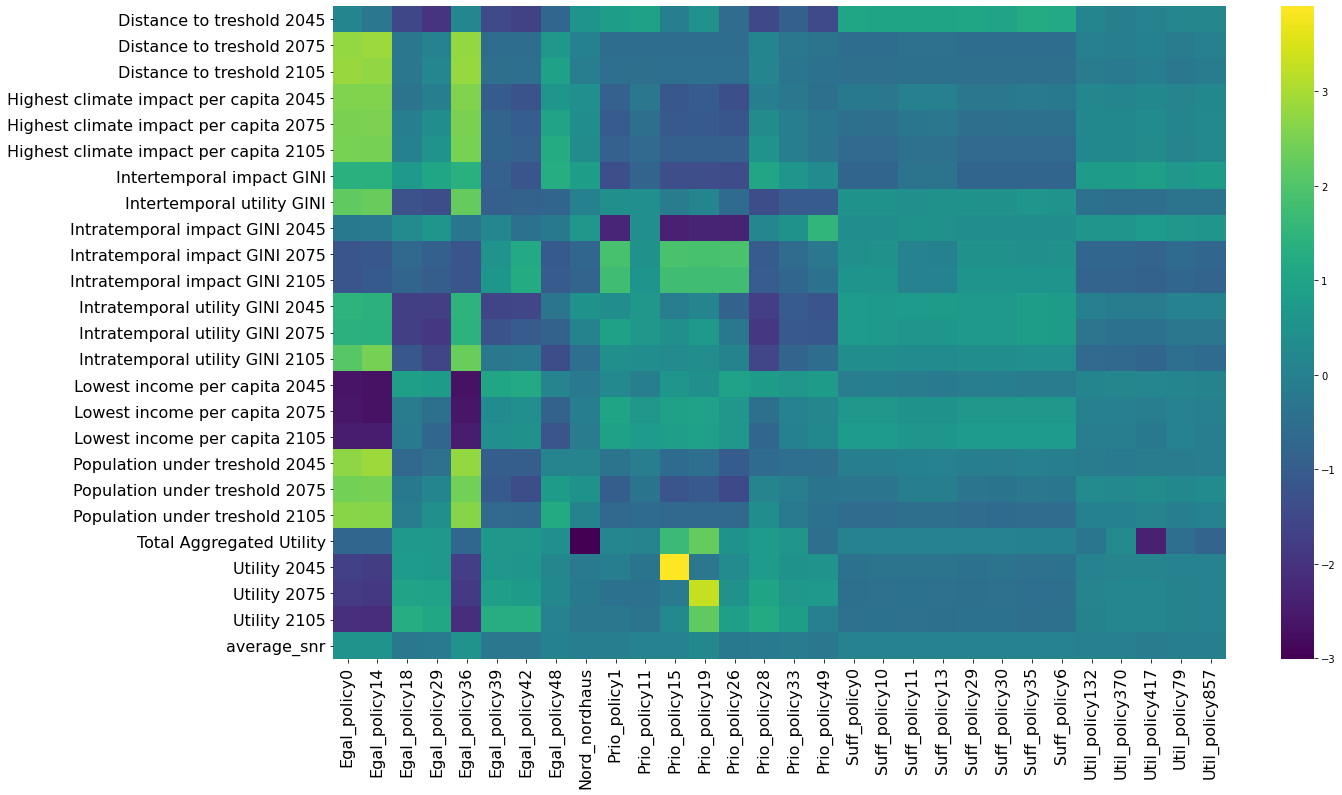

In [16]:
fig, ax = plt.subplots(figsize=(20,12))         
sns.heatmap(scores_norm_mean, cmap='viridis', annot=False,ax=ax)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 16)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 16)
plt.show()

fig.savefig('robustness_snr_heatmap_norm_mean.png', dpi=200,bbox_inches='tight')


In [17]:
scores_min_max=(scores-scores.min())/(scores.max()-scores.min())
scores_min_max["average_snr"] = scores_min_max.mean(axis=1)

scores_min_max = scores_min_max.transpose()
scores_min_max = scores_min_max.sort_index()

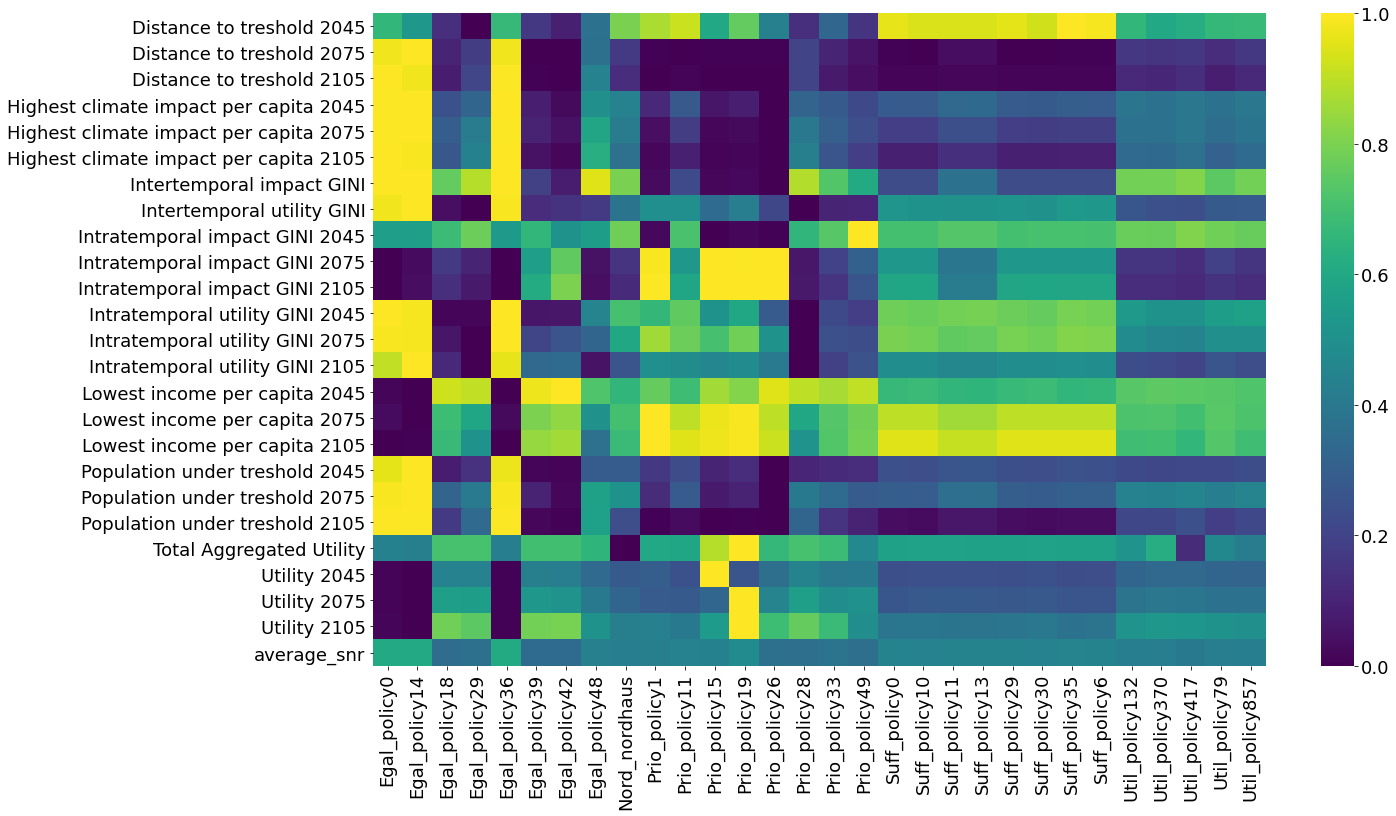

In [18]:
fig, ax = plt.subplots(figsize=(20,12))         
sns.heatmap(scores_min_max, cmap='viridis', annot=False,ax=ax)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 18)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18)
# use matplotlib.colorbar.Colorbar object
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=18)
plt.show()
plt.show()

fig.savefig('robustness_snr_heatmap_min_max_norm.png', dpi=200,bbox_inches='tight')

### Minimax

In [19]:
experiments = results_total_short_term[experiments_columns]
outcomes = results_total_short_term.iloc[:,18:142]

experiments['policy_recoded']=experiments['principle'].astype(str).str[0:4] + "_"+ experiments['policy'] 

<ipython-input-19-52ecee2687e4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experiments['policy_recoded']=experiments['principle'].astype(str).str[0:4] + "_"+ experiments['policy']


In [20]:
experiments_recoded = pd.DataFrame()

for policy in list(experiments['policy_recoded'].unique()):
    df = experiments[experiments['policy_recoded']==policy]
    df = df.reset_index(drop=True)
    df['scenario_recoded'] = df.index
    
    experiments_recoded = pd.concat([df,experiments_recoded])

experiments_recoded = experiments_recoded.drop(['scenario'],axis=1)

In [21]:
overall_regret = {}
max_regret = {}
policy_column = experiments['policy']

for outcome in RICE.outcomes:
    data = pd.DataFrame()
    data[outcome.name] = outcomes[outcome.name]

    data["policy_recoded"] = experiments_recoded['policy_recoded'].reset_index(drop=True)
    data["scenario_recoded"] = experiments_recoded['scenario_recoded'].reset_index(drop=True)

    data = data.pivot(index='scenario_recoded', columns='policy_recoded')
    
    data.columns = data.columns.get_level_values(1)

    if outcome.kind == ScalarOutcome.MINIMIZE:
        outcome_regret = (data.min(axis=1)[:, np.newaxis] - data).abs()
    else:
        outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

max_regret = pd.DataFrame(max_regret)

<ipython-input-21-64f4659b722e>:17: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.min(axis=1)[:, np.newaxis] - data).abs()
<ipython-input-21-64f4659b722e>:19: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()


In [22]:
max_regret_min_max=(max_regret-max_regret.min())/(max_regret.max()-max_regret.min())
max_regret_min_max["average_minmax"] = max_regret_min_max.mean(axis=1)

In [23]:
max_regret_min_max = max_regret_min_max.transpose()
max_regret_min_max = max_regret_min_max.sort_index()

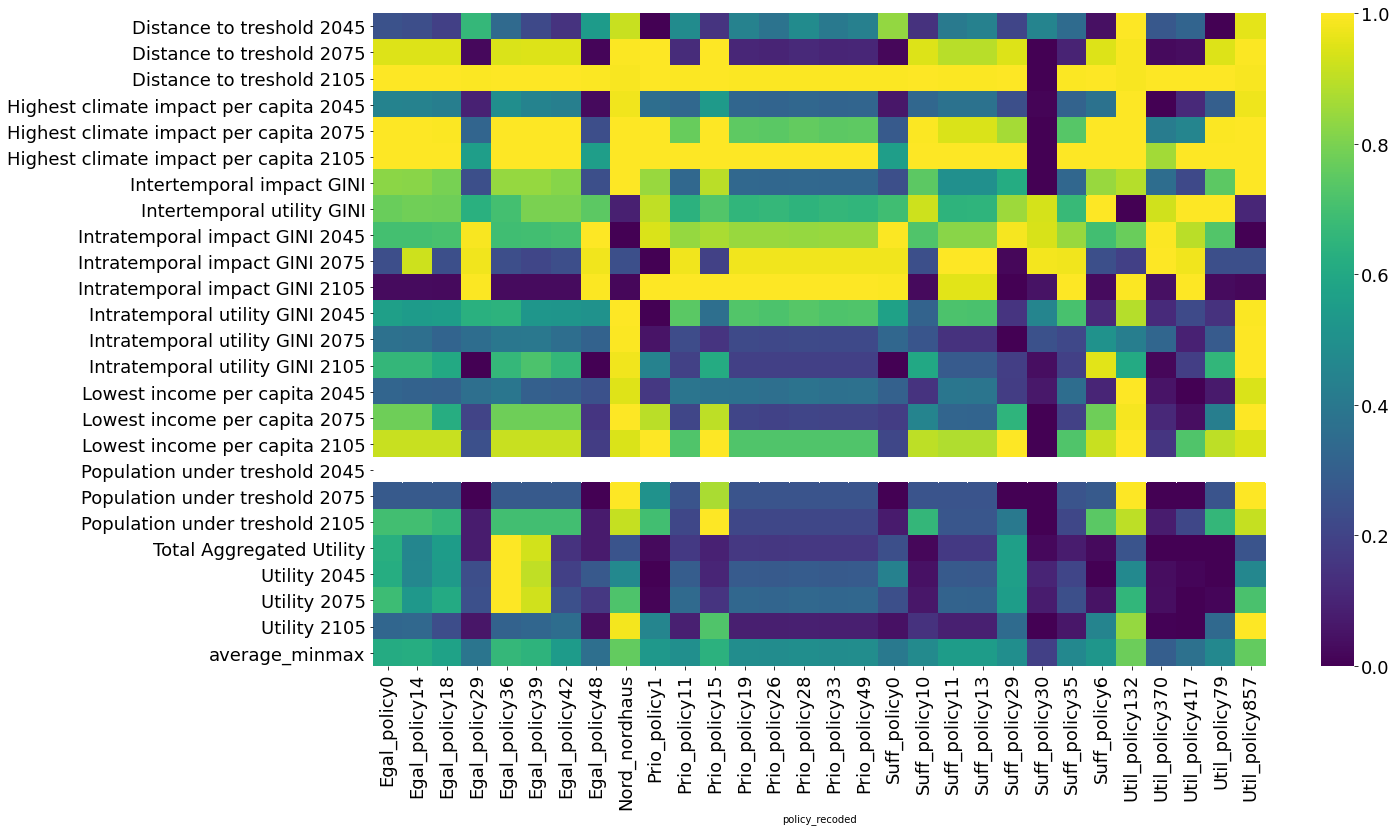

In [24]:
fig, ax = plt.subplots(figsize=(20,12))         
sns.heatmap(max_regret_min_max, cmap='viridis', annot=False,ax=ax)

ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 18)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18)

# use matplotlib.colorbar.Colorbar object
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=18)
plt.show()

fig.savefig('robustness_max_regret_heatmap_min_max_norm.png', dpi=200,bbox_inches='tight')

In [25]:
max_regret_norm_mean=(abs(max_regret-max_regret.mean()))/max_regret.std()
max_regret_norm_mean["average_minmax"] = max_regret_norm_mean.mean(axis=1)
max_regret_norm_mean = max_regret_norm_mean.transpose()
max_regret_norm_mean = max_regret_norm_mean.sort_index()

# scatter based on mean normalisation

In [26]:
#scatter_df = pd.DataFrame()
#scatter_df["average maximin"] = max_regret_norm_mean.loc["average_minmax"] 
#scatter_df["average snr"] = scores_norm_mean.loc["average_snr"]

#scatter_df['principle'] =""
#
#for i in scatter_df.index:
#    principle = experiments[experiments['policy_recoded']==i]["principle"].unique() 
#   scatter_df['principle'].loc[i] = principle[0]

In [27]:
#sns.set(font_scale=1.2)  # crazy big
#sns.set_style("whitegrid")

#a4_dims = (8,8)
#fig, ax = pyplot.subplots(figsize=a4_dims)
#sns.scatterplot(data=scatter_df, x=scatter_df["average maximin"], y=scatter_df["average snr"],s=70,hue=scatter_df["principle"],ax=ax)
#plot = sns.jointplot(height = 7,data=scatter_df, x="average maximin", 
#              y="average snr", hue="principle",s=70)


## Scatter based on max normalisation

In [28]:
scatter_df = pd.DataFrame()
scatter_df["Average maximum regret"] = max_regret_min_max.loc["average_minmax"]
scatter_df["Average SNR robustness"] = scores_min_max.loc["average_snr"]

scatter_df['principle'] =""

for i in scatter_df.index:
    principle = experiments[experiments['policy_recoded']==i]["principle"].unique() 
    scatter_df['principle'].loc[i] = principle[0]

C:\Users\ivart\anaconda3\lib\site-packages\pandas\core\indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [29]:
overview_df = pd.merge(scatter_df, policy_df, left_index=True, right_index=True)
overview_df = overview_df.sort_values(['Average maximum regret'],ascending=True)
overview_df = overview_df.sort_values(['Average SNR robustness'],ascending=False)

filtered_df = overview_df[overview_df.index.get_level_values('policy_recoded').isin(['Prio_policy19',"Suff_policy30","Egal_policy36","Util_policy370","Nord_nordhaus"])]
filtered_df.to_excel("overview_uncertainties_policy_conclusion.xlsx")

C:\Users\ivart\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\ivart\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


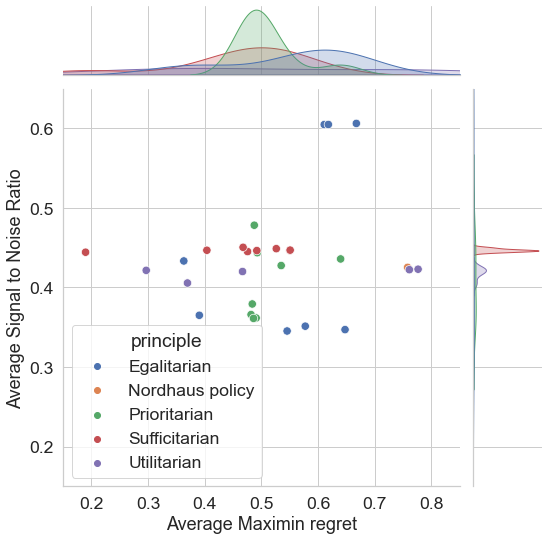

In [39]:
sns.set(font_scale=1.6)  # crazy big
sns.set_style("whitegrid")

#a4_dims = (8,8)
#fig, ax = pyplot.subplots(figsize=a4_dims)
#sns.scatterplot(data=scatter_df, x=scatter_df["average maximin"], y=scatter_df["average snr"],s=70,hue=scatter_df["principle"],ax=ax)
plot = sns.jointplot(height = 8,data=scatter_df, x="Average maximum regret", 
              y="Average SNR robustness", hue="principle",s=70)

#plot.fig.suptitle("Comparision of average robustness vs. max regret",fontsize = "large")
#plot.set(xlabel = "Average Maximin regret", ylabel='Average Signal to Noise ratio')
plot.set_axis_labels('Average Maximin regret', 'Average Signal to Noise Ratio', fontsize=18)

plot.fig.subplots_adjust(top=0.95) # Reduce plot to make room 

plot.ax_marg_x.set_xlim(0.15, 0.85)
plot.ax_marg_y.set_ylim(0.15, 0.65)

plot.savefig('Comparision_of_average_robustness_vs._max_regret.png',dpi = 200)


In [37]:
scatter_df

,Average maximum regret,Average SNR robustness,principle
policy_recoded,,,
Egal_policy0,0.610948,0.604822,Egalitarian
Egal_policy14,0.618207,0.604906,Egalitarian
Egal_policy18,0.577461,0.351323,Egalitarian
Egal_policy29,0.390479,0.365010,Egalitarian
Egal_policy36,0.667626,0.606240,Egalitarian
Egal_policy39,0.647664,0.347005,Egalitarian
Egal_policy42,0.545402,0.345261,Egalitarian
Egal_policy48,0.363082,0.433311,Egalitarian
Nord_nordhaus,0.758143,0.425252,Nordhaus policy
